In [1]:
import os
import time
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from scipy import sparse as ssp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn

from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/추천시스템/df_15.csv')
df.head()

ratings = df[['author_id','product_name','rating_user', 'skin_type', 'secondary_category']]


ratings

,author_id,product_name,rating_user,skin_type,secondary_category
0,35439265952,Soy Hydrating Gentle Face Cleanser,4,combination,Cleansers
1,23201047799,Soy Hydrating Gentle Face Cleanser,1,combination,Cleansers
2,6559471539,Soy Hydrating Gentle Face Cleanser,5,combination,Cleansers
3,23048849960,Soy Hydrating Gentle Face Cleanser,3,dry,Cleansers
4,1405351453,Soy Hydrating Gentle Face Cleanser,1,normal,Cleansers
...,...,...,...,...,...
61694,33409016682,Multi Action Clear Acne Clearing Treatment Lot...,5,normal,Treatments
61695,2555611347,Multi Action Clear Acne Clearing Treatment Lot...,5,dry,Treatments
61696,6747641337,Multi Action Clear Acne Clearing Treatment Lot...,5,normal,Treatments
61697,12175422344,Multi Action Clear Acne Clearing Treatment Lot...,5,normal,Treatments


In [5]:
ratings = ratings.rename(columns= {'author_id' : 'user', 'product_name' : 'item', 'secondary_category' : 'category', 'rating_user': 'rating'})
unique_users = ratings['user'].unique()
unique_items = ratings['item'].unique()


# 고유한 사용자, 피부 타입, 아이템, 카테고리
unique_users = ratings['user'].unique()
unique_items = ratings['item'].unique()
unique_skin_types = ratings['skin_type'].unique()
unique_categories = ratings['category'].unique()

# 고유한 사용자, 피부 타입, 아이템, 카테고리 수 계싼
n_users = ratings['user'].nunique()
n_skin_types = ratings['skin_type'].nunique()
n_items = ratings['item'].nunique()
n_categories = ratings['category'].nunique()


user2id = {user: idx for idx, user in enumerate(unique_users)} #유저 아이디를 인덱스 번호로 매핑
id2user = {idx: user for idx, user in enumerate(unique_users)} #인덱스 번호를 유저 아이디로 매핑

item2id = {item: idx for idx, item in enumerate(unique_items)} #아이템 아이디를 인덱스 번호로 매핑
id2item = {idx: item for idx, item in enumerate(unique_items)} #인덱스 번호를 아이템 아이디로 매핑

skin_type2id = {skin: idx for idx, skin in enumerate(unique_skin_types)}
id2skin_type = {idx: skin for idx, skin in enumerate(unique_skin_types)}

category2id = {cat: idx for idx, cat in enumerate(unique_categories)}
id2category = {idx: cat for idx, cat in enumerate(unique_categories)}

ratings['user'] = ratings['user'].map(user2id) #ratings dataframe에서, 유저를 인덱스 번호로 바꾸기
ratings['item'] = ratings['item'].map(item2id) #ratings dataframe에서, 아이템을 인덱스 번호로 바꾸기
ratings['skin_type'] = ratings['skin_type'].map(skin_type2id)
ratings['category'] = ratings['category'].map(category2id)

ratings_sorted = ratings.sort_values(by=['user'])
ratings_sorted

,user,item,rating,skin_type,category
0,0,0,4,0,0
35934,0,467,4,0,3
59993,0,1113,3,0,1
60040,0,1115,5,0,3
35689,0,462,3,0,1
...,...,...,...,...,...
61633,2263,1332,5,1,2
24861,2263,270,5,1,2
26157,2263,286,5,1,2
60048,2263,1118,5,1,0


In [6]:
# 각 유저별로 train, validation, test 데이터로 분할 (8:1:1 비율)
train, temp = train_test_split(ratings_sorted, test_size=0.2, stratify=ratings_sorted['user'], random_state=42)
val, test = train_test_split(temp, test_size=0.5, stratify=temp['user'], random_state=42)

In [7]:
train

,user,item,rating,skin_type,category
25728,1117,282,4,3,2
4206,1387,24,5,0,1
2181,1389,12,5,0,0
31355,875,385,5,1,6
41810,1746,586,5,0,2
...,...,...,...,...,...
36825,1918,483,5,0,0
28110,581,317,5,0,1
2608,718,15,5,1,3
33486,860,412,4,1,1


In [8]:
all_items = ratings_sorted['item'].unique()

In [9]:
import pickle

In [10]:
ratings['rating']

,rating
0,4
1,1
2,5
3,3
4,1
...,...
61694,5
61695,5
61696,5
61697,5


In [11]:
result = {
    "train": train,
    "val": val,
    "test": test,
    "all_items": all_items,
    "user2id": user2id,
    "id2user": id2user,
    "item2id": item2id,
    "id2item": id2item,
    "category2id" : category2id,
    "id2category" : id2category,
    "skin_type2id" : skin_type2id,
    "id2skin_type" :id2skin_type
}

In [12]:
with open('ml-100k_splited.pkl', 'wb') as f:
    pickle.dump(result, f)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_neg=4 # 네거티브 샘플링 갯수
n_layers = 4 # GNN 레이어 갯수
dropout=0 # dropout rate
data_path = "./ml-100k_splited.pkl" # 데이터셋 경로
batch_size = 1024 # 훈련 데이터 배치 사이즈
emb_size1 = 8
emb_size2 = 4 # 임베딩 크기
lr = 2e-3
top_k = 20
n_epoch=50

In [14]:
with open(data_path, "rb") as f:
    data = pickle.load(f)

train, val, test, all_items, user2id, id2user, item2id, id2item, skin_type2id, id2skin_type, category2id,id2category = data.values()

In [15]:
# 평점 있음

class MLDataset(Dataset):
    def __init__(self, df, all_items, n_neg=4):
        super().__init__()
        self.n_neg = n_neg
        self.users, self.items, self.ratings, self.skin_types, self.categories, self.labels = self.get_data(df, all_items)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx], self.skin_types[idx], self.categories[idx], self.labels[idx]

    def get_data(self, df, all_items):
        users, pos_items, neg_items, ratings, skin_types, categories = [], [], [], [], [], []
        user_item_set = set(zip(df['user'], df['item'], df['rating'], df['skin_type'], df['category']))

        for u, i, r, s, c in user_item_set:
            users.append(u)
            pos_items.append(i)
            ratings.append(r)  # 평점 추가
            skin_types.append(s)
            categories.append(c)

            for _ in range(self.n_neg):
                neg_item = np.random.choice(all_items)

                while (u, neg_item, r, s, c) in user_item_set:
                    neg_item = np.random.choice(all_items)
                neg_items.append(neg_item)

        return (torch.tensor(users).to(device),
                torch.tensor(pos_items).to(device),
                torch.tensor(neg_items).to(device),
                torch.tensor(ratings).to(device),
                torch.tensor(skin_types).to(device),
                torch.tensor(categories).to(device))  # 평점도 반환


In [16]:
train_dataset = MLDataset(train, all_items )
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [17]:
#다 포함
user_consumed = train.groupby('user').apply(lambda x: list(zip(x['item'], x['rating'], x['skin_type'], x['category']))).to_dict()
val_true = val.groupby('user').apply(lambda x: list(zip(x['item'], x['rating'], x['skin_type'], x['category']))).to_dict()
test_true = test.groupby('user').apply(lambda x: list(zip(x['item'], x['rating'], x['skin_type'], x['category']))).to_dict()

In [18]:
#new

class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_size1, emb_size2, n_layers, user_consumed):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items

        self.emb_user = nn.Embedding(n_users, emb_size1)
        self.emb_item = nn.Embedding(n_items, emb_size1)
        self.emb_skin_types = nn.Embedding(n_users, emb_size2)
        self.emb_categories = nn.Embedding(n_items, emb_size2)

        self.n_layers = n_layers

        self.user_consumed = user_consumed

        self.laplacian_matrix = self._build_laplacian_matrix()
        self._init_weight()


    def _init_weight(self):
        nn.init.normal_(self.emb_user.weight, std=1e-2)
        nn.init.normal_(self.emb_item.weight, std=1e-2)
        nn.init.normal_(self.emb_skin_types.weight, std=1e-2)
        nn.init.normal_(self.emb_categories.weight, std=1e-2)

    def _build_laplacian_matrix(self):
        R = ssp.dok_matrix((self.n_users, self.n_items), dtype=np.float32)

        for u in range(self.n_users):
            for item, rating, skin_type, category in self.user_consumed[u]:  # 아이템과 별점 모두 추출
                R[u, item] = rating * 0.5

        R = R.tolil()

        adj_matrix = ssp.dok_matrix(
            (self.n_users+self.n_items, self.n_items+self.n_users), dtype=np.float32
        )
        adj_matrix[:self.n_users, self.n_users:] = R
        adj_matrix[self.n_users:, :self.n_users] = R.T
        # adj_matrix = adj_matrix.tocsr()

        row_sum = np.array(adj_matrix.sum(axis=1)) # adj의 row sum은 각 유저/아이템 노드의 차수를 의미
        diag_inv = np.power(row_sum, -0.5).flatten()
        diag_inv[np.isinf(diag_inv)] = 0.0
        diag_matrix_inv = ssp.diags(diag_inv) # D^(-1/2)

        coo = diag_matrix_inv.dot(adj_matrix).dot(diag_matrix_inv).tocoo() # D^(-1/2) * A * D^(-1/2)
        indices = torch.from_numpy(np.array([coo.row, coo.col]))
        values = torch.from_numpy(coo.data)
        laplacian_matrix = torch.sparse_coo_tensor(
            indices, values, coo.shape, dtype=torch.float32, device=device
        )
        return laplacian_matrix

    def emb_propagation(self, users, pos_items, skin_types, categories):

        user_emb = self.emb_user.weight
        skin_type_emb = self.emb_skin_types.weight

        self.emb_user_sum = torch.cat([user_emb, skin_type_emb], dim=1)

        item_emb = self.emb_item.weight  # Shape: [n_items, emb_size1]
        category_emb = self.emb_categories.weight  # Shape: [n_categories, emb_size2]


        self.emb_item_sum = torch.cat([item_emb, category_emb], dim=1)  # Shape: [n_items, emb_size1 + emb_size2]

        # Combine user and item embeddings for propagation
        all_emb = [torch.cat([self.emb_user_sum, self.emb_item_sum], dim=0)]

        for _ in range(self.n_layers):
            layered_emb = torch.sparse.mm(self.laplacian_matrix, all_emb[-1])
            all_emb.append(layered_emb)

        all_emb = torch.stack(all_emb, dim=1)
        mean_emb = torch.mean(all_emb, dim=1)

        layered_emb_user, layered_emb_item = torch.split(mean_emb, [self.n_users, self.n_items])
        return layered_emb_user, layered_emb_item

    def forward(self, users, pos_items, neg_items=None):
        # propagation 후 user, pos, neg
        layered_emb_users, layered_emb_items = self.emb_propagation(users, pos_items, skin_types, categories)
        layered_emb_user, layered_pos_emb, layered_neg_emb = layered_emb_users[users], layered_emb_items[pos_items], layered_emb_items[neg_items] if neg_items is not None else None

        return layered_emb_user, layered_pos_emb, layered_neg_emb


In [19]:
import torch.nn.functional as F

def bpr_loss(layered_emb_user, layered_pos_emb, layered_neg_emb):
    # reg loss는 forward return에 있는 init emb를 활용해서 별도 처리하기.
    pos_score = (layered_emb_user * layered_pos_emb).sum(dim=1)
    neg_score = (layered_emb_user * layered_neg_emb).sum(dim=1)
    log_sigmoid = F.logsigmoid(pos_score - neg_score)
    return torch.negative(torch.mean(log_sigmoid))

In [20]:
n_users, n_items, n_skin_types, n_categories = len(user2id), len(item2id), len(skin_type2id), len(category2id)

In [21]:
model = LightGCN(n_users, n_items, emb_size1, emb_size2, n_layers, user_consumed)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

<ipython-input-18-e6ab41a37344>:45: RuntimeWarning: divide by zero encountered in power
  diag_inv = np.power(row_sum, -0.5).flatten()


In [22]:
def get_precision(pred, true, k=20):
    intersection = set(pred).intersection(set(true))
    return len(intersection)/ k

def get_recall(pred, true, k=20):
    intersection = set(pred).intersection(set(true))
    return len(intersection)/len(true)

def get_nDCG(pred, true, k=20):
    intersection, _, idx_in_pred = np.intersect1d(true, pred, assume_unique=True, return_indices=True)
    if intersection.size == 0:
        return 0
    rank_list = np.zeros(k, np.float32)
    rank_list[idx_in_pred] = 1
    ideal_list = np.sort(rank_list)[::-1]
    dcg = np.sum(rank_list/np.log2(np.arange(2, k+2)))
    idcg = np.sum(ideal_list /np.log2(np.arange(2, k+2)))
    return dcg/idcg

In [28]:
#new


for epoch in range(1, n_epoch+1):
    model.train()
    total_loss = []

    for i, batch_data in enumerate(tqdm(train_loader, desc="train")):
        users, pos_items, neg_items, ratings, skin_types, categories = batch_data  # 평점 추가
        layered_emb_user, layered_pos_emb, layered_neg_emb = model(users, pos_items,  neg_items)
        loss = bpr_loss(layered_emb_user, layered_pos_emb, layered_neg_emb)
        total_loss.append(loss.item())

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"epoch: {epoch}, total_loss: {np.mean(total_loss):.4f}")

    # validation
    model.eval()
    recall = np.array([])
    precision = np.array([])
    ndcg = np.array([])

    for u, true_items_ratings in tqdm(val_true.items(), desc="eval"):
        # 유저별 소비하지 않은 아이템
        unconsumed_items = list(set(all_items) - set([item for item, _, _, _ in user_consumed[u]]))  # 아이템만 추출
        unconsumed_items = torch.tensor(unconsumed_items).to(device)
        u = torch.tensor(u).to(device)

        # 추론
        layered_emb_user, layered_emb_item, _ = model(u, unconsumed_items)
        pred = (layered_emb_user * layered_emb_item).sum(dim=-1)
        _, pred_idx = torch.topk(pred, k=top_k)
        top_k_items = unconsumed_items[pred_idx].tolist()

        # 실제 아이템만 추출 (별점 제외)
        true_items = [item for item, _, _, _ in true_items_ratings]

        # 메트릭
        recall = np.append(recall, get_recall(top_k_items, true_items, k=top_k))
        precision = np.append(precision, get_precision(top_k_items, true_items, k=top_k))
        ndcg = np.append(ndcg, get_nDCG(top_k_items, true_items, k=top_k))

    print(f"recall:{np.mean(recall):.4f}\nprecision:{np.mean(precision):.4f}\nndcg:{np.mean(ndcg):.4f}")

# validation
model.eval()
recall = np.array([])
precision = np.array([])
ndcg = np.array([])

for u, true_items_ratings in tqdm(test_true.items(), desc="test"):
    # 유저별 소비하지 않은 아이템
    unconsumed_items = list(set(all_items) - set([item for item, _, _, _ in user_consumed[u]]))  # 아이템만 추출
    unconsumed_items = torch.tensor(unconsumed_items).to(device)
    u = torch.tensor(u).to(device)

    # 추론
    layered_emb_user, layered_emb_item, _ = model(u, unconsumed_items)
    pred = (layered_emb_user * layered_emb_item).sum(dim=-1)
    _, pred_idx = torch.topk(pred, k=top_k)
    top_k_items = unconsumed_items[pred_idx].tolist()

    # 실제 아이템만 추출 (별점 제외)
    true_items = [item for item, _, _, _ in true_items_ratings]

    # 메트릭
    recall = np.append(recall, get_recall(top_k_items, true_items, k=top_k))
    precision = np.append(precision, get_precision(top_k_items, true_items, k=top_k))
    ndcg = np.append(ndcg, get_nDCG(top_k_items, true_items, k=top_k))

print(f"recall:{np.mean(recall):.4f}\nprecision:{np.mean(precision):.4f}\nndcg:{np.mean(ndcg):.4f}")


train: 100%|██████████| 48/48 [00:02<00:00, 22.37it/s]


epoch: 1, total_loss: 0.2231


eval: 100%|██████████| 2264/2264 [00:07<00:00, 308.45it/s]


recall:0.2354
precision:0.0327
ndcg:0.2183


train: 100%|██████████| 48/48 [00:01<00:00, 31.35it/s]


epoch: 2, total_loss: 0.2221


eval: 100%|██████████| 2264/2264 [00:08<00:00, 271.64it/s]


recall:0.2339
precision:0.0325
ndcg:0.2173


train: 100%|██████████| 48/48 [00:01<00:00, 31.36it/s]


epoch: 3, total_loss: 0.2210


eval: 100%|██████████| 2264/2264 [00:08<00:00, 277.77it/s]


recall:0.2337
precision:0.0325
ndcg:0.2176


train: 100%|██████████| 48/48 [00:01<00:00, 28.39it/s]


epoch: 4, total_loss: 0.2200


eval: 100%|██████████| 2264/2264 [00:07<00:00, 313.69it/s]


recall:0.2346
precision:0.0326
ndcg:0.2174


train: 100%|██████████| 48/48 [00:01<00:00, 29.78it/s]


epoch: 5, total_loss: 0.2189


eval: 100%|██████████| 2264/2264 [00:08<00:00, 275.26it/s]


recall:0.2348
precision:0.0326
ndcg:0.2174


train: 100%|██████████| 48/48 [00:01<00:00, 31.69it/s]


epoch: 6, total_loss: 0.2178


eval: 100%|██████████| 2264/2264 [00:08<00:00, 272.92it/s]


recall:0.2326
precision:0.0324
ndcg:0.2164


train: 100%|██████████| 48/48 [00:01<00:00, 30.89it/s]


epoch: 7, total_loss: 0.2168


eval: 100%|██████████| 2264/2264 [00:07<00:00, 313.35it/s]


recall:0.2341
precision:0.0326
ndcg:0.2171


train: 100%|██████████| 48/48 [00:02<00:00, 22.75it/s]


epoch: 8, total_loss: 0.2157


eval: 100%|██████████| 2264/2264 [00:07<00:00, 288.22it/s]


recall:0.2351
precision:0.0326
ndcg:0.2179


train: 100%|██████████| 48/48 [00:01<00:00, 31.48it/s]


epoch: 9, total_loss: 0.2145


eval: 100%|██████████| 2264/2264 [00:08<00:00, 276.42it/s]


recall:0.2345
precision:0.0326
ndcg:0.2174


train: 100%|██████████| 48/48 [00:01<00:00, 31.66it/s]


epoch: 10, total_loss: 0.2134


eval: 100%|██████████| 2264/2264 [00:07<00:00, 301.79it/s]


recall:0.2349
precision:0.0326
ndcg:0.2175


train: 100%|██████████| 48/48 [00:02<00:00, 20.93it/s]


epoch: 11, total_loss: 0.2122


eval: 100%|██████████| 2264/2264 [00:07<00:00, 305.64it/s]


recall:0.2349
precision:0.0326
ndcg:0.2172


train: 100%|██████████| 48/48 [00:01<00:00, 31.78it/s]


epoch: 12, total_loss: 0.2110


eval: 100%|██████████| 2264/2264 [00:08<00:00, 274.81it/s]


recall:0.2349
precision:0.0325
ndcg:0.2179


train: 100%|██████████| 48/48 [00:01<00:00, 31.46it/s]


epoch: 13, total_loss: 0.2097


eval: 100%|██████████| 2264/2264 [00:07<00:00, 284.71it/s]


recall:0.2352
precision:0.0325
ndcg:0.2184


train: 100%|██████████| 48/48 [00:01<00:00, 25.66it/s]


epoch: 14, total_loss: 0.2085


eval: 100%|██████████| 2264/2264 [00:07<00:00, 314.19it/s]


recall:0.2355
precision:0.0325
ndcg:0.2186


train: 100%|██████████| 48/48 [00:01<00:00, 31.42it/s]


epoch: 15, total_loss: 0.2073


eval: 100%|██████████| 2264/2264 [00:08<00:00, 277.92it/s]


recall:0.2359
precision:0.0327
ndcg:0.2186


train: 100%|██████████| 48/48 [00:01<00:00, 31.50it/s]


epoch: 16, total_loss: 0.2060


eval: 100%|██████████| 2264/2264 [00:08<00:00, 275.55it/s]


recall:0.2355
precision:0.0327
ndcg:0.2182


train: 100%|██████████| 48/48 [00:01<00:00, 31.50it/s]


epoch: 17, total_loss: 0.2047


eval: 100%|██████████| 2264/2264 [00:07<00:00, 317.99it/s]


recall:0.2362
precision:0.0327
ndcg:0.2182


train: 100%|██████████| 48/48 [00:01<00:00, 27.23it/s]


epoch: 18, total_loss: 0.2034


eval: 100%|██████████| 2264/2264 [00:08<00:00, 266.59it/s]


recall:0.2370
precision:0.0327
ndcg:0.2188


train: 100%|██████████| 48/48 [00:02<00:00, 21.04it/s]


epoch: 19, total_loss: 0.2021


eval: 100%|██████████| 2264/2264 [00:08<00:00, 272.51it/s]


recall:0.2379
precision:0.0329
ndcg:0.2191


train: 100%|██████████| 48/48 [00:01<00:00, 31.43it/s]


epoch: 20, total_loss: 0.2008


eval: 100%|██████████| 2264/2264 [00:07<00:00, 295.31it/s]


recall:0.2395
precision:0.0331
ndcg:0.2195


train: 100%|██████████| 48/48 [00:02<00:00, 22.45it/s]


epoch: 21, total_loss: 0.1995


eval: 100%|██████████| 2264/2264 [00:07<00:00, 312.76it/s]


recall:0.2404
precision:0.0331
ndcg:0.2205


train: 100%|██████████| 48/48 [00:01<00:00, 31.51it/s]


epoch: 22, total_loss: 0.1982


eval: 100%|██████████| 2264/2264 [00:08<00:00, 272.96it/s]


recall:0.2405
precision:0.0331
ndcg:0.2204


train: 100%|██████████| 48/48 [00:01<00:00, 31.47it/s]


epoch: 23, total_loss: 0.1970


eval: 100%|██████████| 2264/2264 [00:08<00:00, 279.44it/s]


recall:0.2400
precision:0.0331
ndcg:0.2204


train: 100%|██████████| 48/48 [00:01<00:00, 29.33it/s]


epoch: 24, total_loss: 0.1957


eval: 100%|██████████| 2264/2264 [00:07<00:00, 313.02it/s]


recall:0.2422
precision:0.0334
ndcg:0.2210


train: 100%|██████████| 48/48 [00:01<00:00, 29.64it/s]


epoch: 25, total_loss: 0.1945


eval: 100%|██████████| 2264/2264 [00:08<00:00, 277.76it/s]


recall:0.2421
precision:0.0334
ndcg:0.2216


train: 100%|██████████| 48/48 [00:01<00:00, 31.77it/s]


epoch: 26, total_loss: 0.1933


eval: 100%|██████████| 2264/2264 [00:08<00:00, 267.16it/s]


recall:0.2418
precision:0.0334
ndcg:0.2219


train: 100%|██████████| 48/48 [00:01<00:00, 31.28it/s]


epoch: 27, total_loss: 0.1921


eval: 100%|██████████| 2264/2264 [00:07<00:00, 306.70it/s]


recall:0.2431
precision:0.0335
ndcg:0.2228


train: 100%|██████████| 48/48 [00:02<00:00, 21.02it/s]


epoch: 28, total_loss: 0.1909


eval: 100%|██████████| 2264/2264 [00:07<00:00, 283.68it/s]


recall:0.2423
precision:0.0334
ndcg:0.2229


train: 100%|██████████| 48/48 [00:01<00:00, 29.84it/s]


epoch: 29, total_loss: 0.1898


eval: 100%|██████████| 2264/2264 [00:08<00:00, 272.68it/s]


recall:0.2424
precision:0.0334
ndcg:0.2232


train: 100%|██████████| 48/48 [00:01<00:00, 30.63it/s]


epoch: 30, total_loss: 0.1887


eval: 100%|██████████| 2264/2264 [00:07<00:00, 293.89it/s]


recall:0.2426
precision:0.0334
ndcg:0.2233


train: 100%|██████████| 48/48 [00:02<00:00, 21.06it/s]


epoch: 31, total_loss: 0.1876


eval: 100%|██████████| 2264/2264 [00:07<00:00, 306.29it/s]


recall:0.2430
precision:0.0334
ndcg:0.2235


train: 100%|██████████| 48/48 [00:01<00:00, 29.65it/s]


epoch: 32, total_loss: 0.1865


eval: 100%|██████████| 2264/2264 [00:08<00:00, 267.72it/s]


recall:0.2431
precision:0.0335
ndcg:0.2231


train: 100%|██████████| 48/48 [00:01<00:00, 30.07it/s]


epoch: 33, total_loss: 0.1855


eval: 100%|██████████| 2264/2264 [00:08<00:00, 270.34it/s]


recall:0.2423
precision:0.0333
ndcg:0.2227


train: 100%|██████████| 48/48 [00:01<00:00, 31.64it/s]


epoch: 34, total_loss: 0.1845


eval: 100%|██████████| 2264/2264 [00:07<00:00, 312.45it/s]


recall:0.2437
precision:0.0335
ndcg:0.2231


train: 100%|██████████| 48/48 [00:01<00:00, 26.49it/s]


epoch: 35, total_loss: 0.1835


eval: 100%|██████████| 2264/2264 [00:08<00:00, 276.51it/s]


recall:0.2425
precision:0.0334
ndcg:0.2228


train: 100%|██████████| 48/48 [00:01<00:00, 30.19it/s]


epoch: 36, total_loss: 0.1825


eval: 100%|██████████| 2264/2264 [00:08<00:00, 274.19it/s]


recall:0.2428
precision:0.0334
ndcg:0.2227


train: 100%|██████████| 48/48 [00:01<00:00, 30.27it/s]


epoch: 37, total_loss: 0.1816


eval: 100%|██████████| 2264/2264 [00:07<00:00, 304.81it/s]


recall:0.2431
precision:0.0335
ndcg:0.2224


train: 100%|██████████| 48/48 [00:02<00:00, 19.56it/s]


epoch: 38, total_loss: 0.1807


eval: 100%|██████████| 2264/2264 [00:07<00:00, 290.66it/s]


recall:0.2418
precision:0.0333
ndcg:0.2222


train: 100%|██████████| 48/48 [00:01<00:00, 29.49it/s]


epoch: 39, total_loss: 0.1797


eval: 100%|██████████| 2264/2264 [00:08<00:00, 267.15it/s]


recall:0.2426
precision:0.0334
ndcg:0.2219


train: 100%|██████████| 48/48 [00:01<00:00, 29.52it/s]


epoch: 40, total_loss: 0.1789


eval: 100%|██████████| 2264/2264 [00:08<00:00, 277.03it/s]


recall:0.2424
precision:0.0334
ndcg:0.2213


train: 100%|██████████| 48/48 [00:02<00:00, 23.87it/s]


epoch: 41, total_loss: 0.1780


eval: 100%|██████████| 2264/2264 [00:07<00:00, 304.28it/s]


recall:0.2425
precision:0.0334
ndcg:0.2214


train: 100%|██████████| 48/48 [00:01<00:00, 28.86it/s]


epoch: 42, total_loss: 0.1771


eval: 100%|██████████| 2264/2264 [00:08<00:00, 271.88it/s]


recall:0.2427
precision:0.0334
ndcg:0.2213


train: 100%|██████████| 48/48 [00:01<00:00, 29.80it/s]


epoch: 43, total_loss: 0.1763


eval: 100%|██████████| 2264/2264 [00:08<00:00, 269.15it/s]


recall:0.2428
precision:0.0334
ndcg:0.2215


train: 100%|██████████| 48/48 [00:01<00:00, 29.46it/s]


epoch: 44, total_loss: 0.1754


eval: 100%|██████████| 2264/2264 [00:07<00:00, 303.52it/s]


recall:0.2435
precision:0.0334
ndcg:0.2216


train: 100%|██████████| 48/48 [00:02<00:00, 20.10it/s]


epoch: 45, total_loss: 0.1746


eval: 100%|██████████| 2264/2264 [00:07<00:00, 292.97it/s]


recall:0.2438
precision:0.0334
ndcg:0.2212


train: 100%|██████████| 48/48 [00:01<00:00, 30.27it/s]


epoch: 46, total_loss: 0.1738


eval: 100%|██████████| 2264/2264 [00:08<00:00, 271.35it/s]


recall:0.2431
precision:0.0334
ndcg:0.2211


train: 100%|██████████| 48/48 [00:01<00:00, 30.65it/s]


epoch: 47, total_loss: 0.1730


eval: 100%|██████████| 2264/2264 [00:08<00:00, 278.27it/s]


recall:0.2433
precision:0.0334
ndcg:0.2215


train: 100%|██████████| 48/48 [00:01<00:00, 25.38it/s]


epoch: 48, total_loss: 0.1722


eval: 100%|██████████| 2264/2264 [00:07<00:00, 308.32it/s]


recall:0.2419
precision:0.0333
ndcg:0.2204


train: 100%|██████████| 48/48 [00:01<00:00, 30.48it/s]


epoch: 49, total_loss: 0.1715


eval: 100%|██████████| 2264/2264 [00:08<00:00, 272.37it/s]


recall:0.2409
precision:0.0331
ndcg:0.2196


train: 100%|██████████| 48/48 [00:01<00:00, 30.27it/s]


epoch: 50, total_loss: 0.1707


eval: 100%|██████████| 2264/2264 [00:09<00:00, 235.90it/s]


recall:0.2415
precision:0.0332
ndcg:0.2194


test: 100%|██████████| 2264/2264 [00:07<00:00, 311.95it/s]

recall:0.2389
precision:0.0329
ndcg:0.2248


In [29]:
#new
import json

# validation
model.eval()
recall = np.array([])
precision = np.array([])
ndcg = np.array([])

# 유저별 추천 결과를 저장할 딕셔너리
user_recommendations = {}

for u, true_items_ratings in tqdm(test_true.items(), desc="test"):
    # 유저별 소비하지 않은 아이템
    unconsumed_items = list(set(all_items) - set([item for item, _, _, _ in user_consumed[u]]))  # 아이템만 추출
    unconsumed_items = torch.tensor(unconsumed_items).to(device)
    u = torch.tensor(u).to(device)

    # 추론
    layered_emb_user, layered_emb_item, _ = model(u, unconsumed_items)
    pred = (layered_emb_user * layered_emb_item).sum(dim=-1)
    _, pred_idx = torch.topk(pred, k=top_k)
    top_k_items = unconsumed_items[pred_idx].tolist()

    # 실제 아이템만 추출 (별점 제외)
    true_items = [item for item, _, _, _ in true_items_ratings]

    # 메트릭
    recall = np.append(recall, get_recall(top_k_items, true_items, k=top_k))
    precision = np.append(precision, get_precision(top_k_items, true_items, k=top_k))
    ndcg = np.append(ndcg, get_nDCG(top_k_items, true_items, k=top_k))

    # 유저별 추천 결과 저장
    user_recommendations[str(u.item())] = {
        'top_k_items': top_k_items,
        'true_items': true_items
    }

with open('user_recommendations.json', 'w') as f:
    json.dump(user_recommendations, f)


print(f"recall:{np.mean(recall):.4f}\nprecision:{np.mean(precision):.4f}\nndcg:{np.mean(ndcg):.4f}")

test: 100%|██████████| 2264/2264 [00:08<00:00, 268.21it/s]


recall:0.2389
precision:0.0329
ndcg:0.2248


In [25]:
import json
import pandas as pd
import numpy as np

# product_id_mapping
product_df = df[['product_name', 'brand_name', 'highlights', 'secondary_category', 'skin_type']]
product_df = product_df.drop_duplicates()
product_mapping = {
    row['product_name']: (row['brand_name'], row['highlights'], row['secondary_category'], row['skin_type'])
    for _, row in product_df.iterrows()
}

# JSON 파일에서 추천 결과 불러오기
with open('user_recommendations.json', 'r') as f:
    user_recommendations = json.load(f)

recommendations_dict = {}

# 결과를 출력할 함수
def print_recommendations(user_recommendations, id2user, id2item):
    # 랜덤으로 3명의 유저 선택
    selected_users = np.random.choice(list(user_recommendations.keys()), size=3, replace=False)

    for user in selected_users:
        recommendations_list = []
        user_id = id2user[int(user)]  # 인덱스를 원래 user_id로 변환
        top_k_items = user_recommendations[user]['top_k_items']
        top_k_items_names = [id2item[int(item)] for item in top_k_items]  # 인덱스를 원래 item_name으로 변환
        consumed_items = [id2item[item] for item in user_recommendations[user]['true_items']]

        # 해당 유저의 피부 타입
        skin_types = list(df[df['author_id'] == user_id]['skin_type'].unique())
        print(f"User: {user_id}, Skin Type: {skin_types}")

        # 추천 아이템에 순위 추가
        for rank, item_name in enumerate(top_k_items_names, start=1):
            brand, highlights, category, _ = product_mapping[item_name]
            recommendations_list.append({
                'User ID': user_id,
                'Skin Type': skin_types,
                'Product Name': item_name,
                'Brand': brand,
                'Highlights': highlights,
                'Category': category,
                'Ranking': rank
            })

        # 소비한 아이템 추가
        for item_name in consumed_items:
            brand, highlights, category, _ = product_mapping[item_name]
            recommendations_list.append({
                'User ID': user_id,
                'Skin Type': skin_types,
                'Product Name': item_name,
                'Brand': brand,
                'Highlights': highlights,
                'Category': category,
                'Ranking': 'used'
            })

        # DataFrame으로 변환하여 저장
        recommendations_dict[user_id] = pd.DataFrame(recommendations_list)

# 추천 결과 출력
print_recommendations(user_recommendations, id2user, id2item)

User: 23063771539, Skin Type: ['combination']
User: 25840494474, Skin Type: ['combination']
User: 6665604756, Skin Type: ['normal']


<ipython-input-26-cad33be15191>:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Pastel1', len(unique_cat))


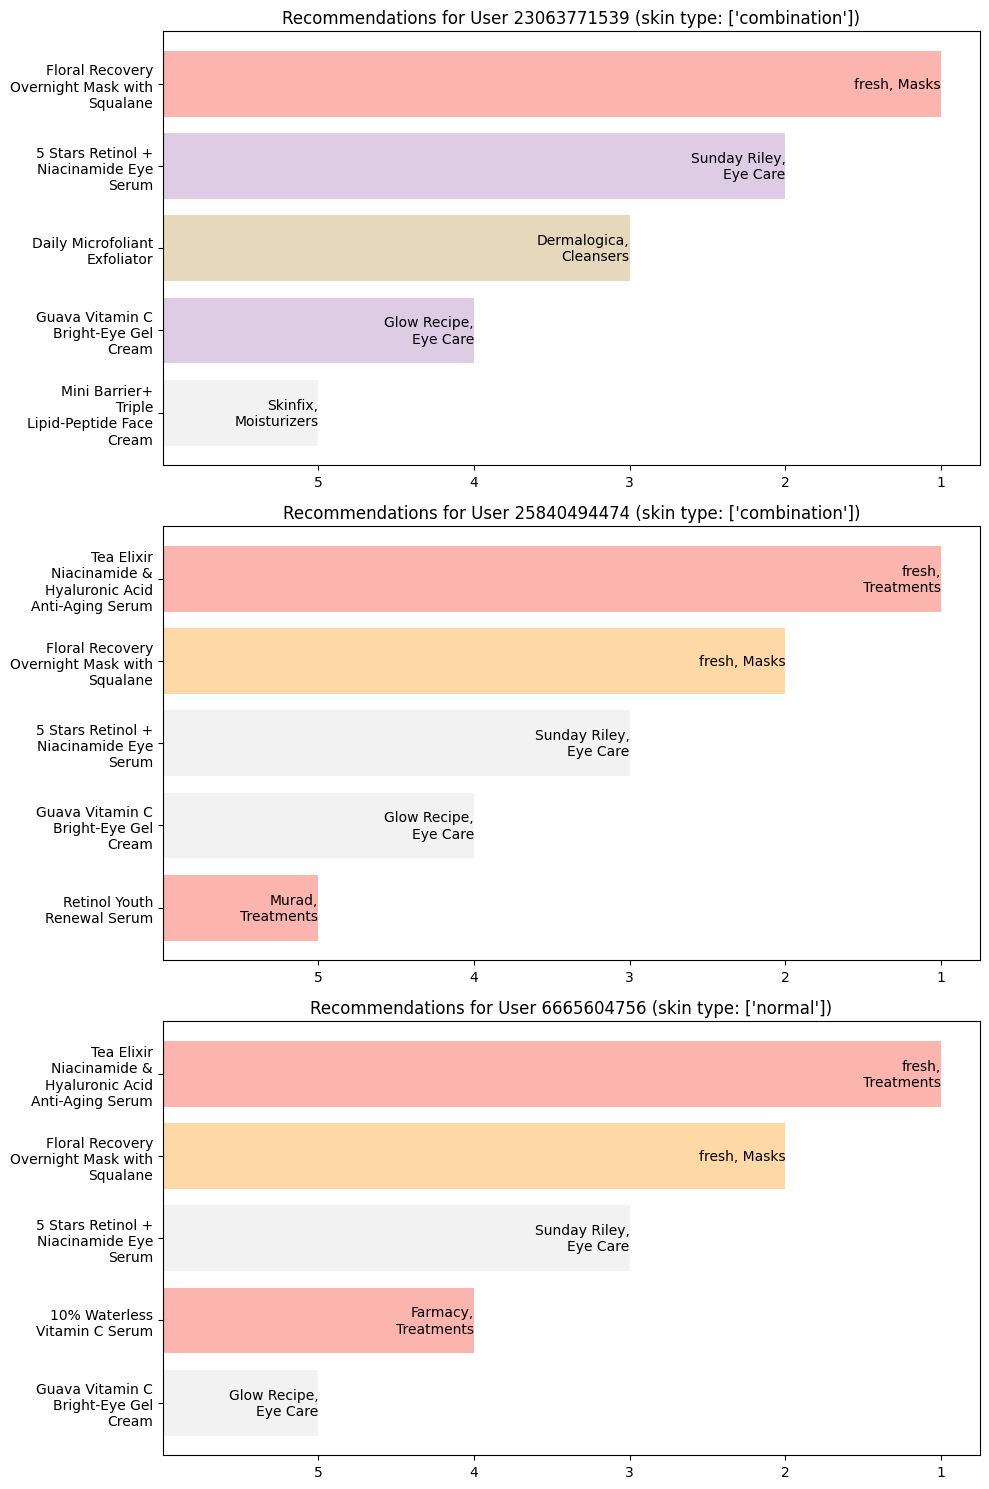

In [26]:
import matplotlib.pyplot as plt
def wrap_text(name, max_length=20):
    words = name.split(' ')
    wrapped_lines = []
    current_line = ""

    for word in words:
        # Check if adding the next word exceeds the maximum length
        if len(current_line) + len(word) + 1 <= max_length:
            current_line += (word + ' ')
        else:
            wrapped_lines.append(current_line.strip())
            current_line = word + ' '  # Start a new line with the current word

    # Append any remaining words in the last line
    if current_line:
        wrapped_lines.append(current_line.strip())

    return '\n'.join(wrapped_lines)

# 유저 추천 결과 시각화
unique_user_ids = recommendations_dict.keys()
num_users = len(unique_user_ids)
fig, axes = plt.subplots(num_users, 1, figsize=(10, 5 * num_users))

for i, user_id in enumerate(unique_user_ids):
    user_recommendations = recommendations_dict[user_id]
    user_recommendations = user_recommendations[:5]
    skin_type = user_recommendations['Skin Type'][0]

    # 같은 브랜드는 같은 색상으로
    unique_cat = user_recommendations['Category'].unique()
    colors = plt.cm.get_cmap('Pastel1', len(unique_cat))
    brand_color_map = {brand: colors(j) for j, brand in enumerate(unique_cat)}

    # 막대그래프 생성
    axes[i].barh(user_recommendations['Product Name'].apply(wrap_text),
                 6 - user_recommendations['Ranking'],  # Ranking을 사용
                 color=[brand_color_map[brand] for brand in user_recommendations['Category']])

    # Add brand and category as text labels above the bars
    for j, (product_name, brand, category) in enumerate(zip(user_recommendations['Product Name'], user_recommendations['Brand'], user_recommendations['Category'])):
        label_text = f"{brand}, {category}"
        wrapped_label = wrap_text(label_text, max_length=15)
        axes[i].text(6 - user_recommendations['Ranking'].iloc[j], j,
                      wrapped_label,
                      va='center',
                      ha='right')

    # Set x-ticks to show ranks 5, 4, 3, 2, 1
    axes[i].set_xticks([1, 2, 3, 4, 5])
    axes[i].set_xticklabels([5, 4, 3, 2, 1])

    # 그래프 제목 및 y축 반전
    axes[i].set_title(f'Recommendations for User {user_id} (skin type: {skin_type})')
    axes[i].invert_yaxis()

plt.tight_layout()
plt.show()
